# Import libraries

In [5]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model

DOWNLOAD_ROOT = "http://vision.stanford.edu/aditya86/ImageNetDogs/"
FILENAME = "images.tar"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
data_dir = Path(filepath).parent / "Images"
data_dir

WindowsPath('C:/Users/Tharun/.keras/datasets/Images')

In [6]:
class_names = os.listdir(data_dir)
n_classes = len(os.listdir(data_dir))

n_images = 0
for i in range(n_classes):
    n_images += len(os.listdir(data_dir / class_names[i]))
print("Number of images: ", n_images)
print("Number of classes: ", n_classes)

Number of images:  20580
Number of classes:  120


# Lets observe the Data

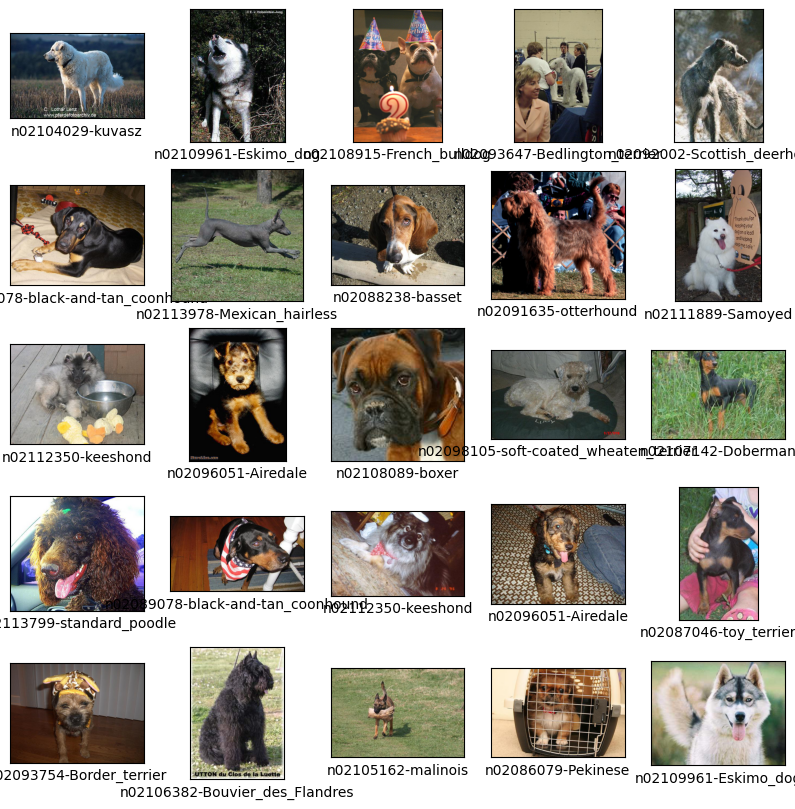

In [3]:
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    class_name = random.choice(class_names)
    file_name = random.choice(os.listdir(data_dir / class_name))
    image = plt.imread(data_dir / class_name / file_name)
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.xlabel(class_name)
plt.show()


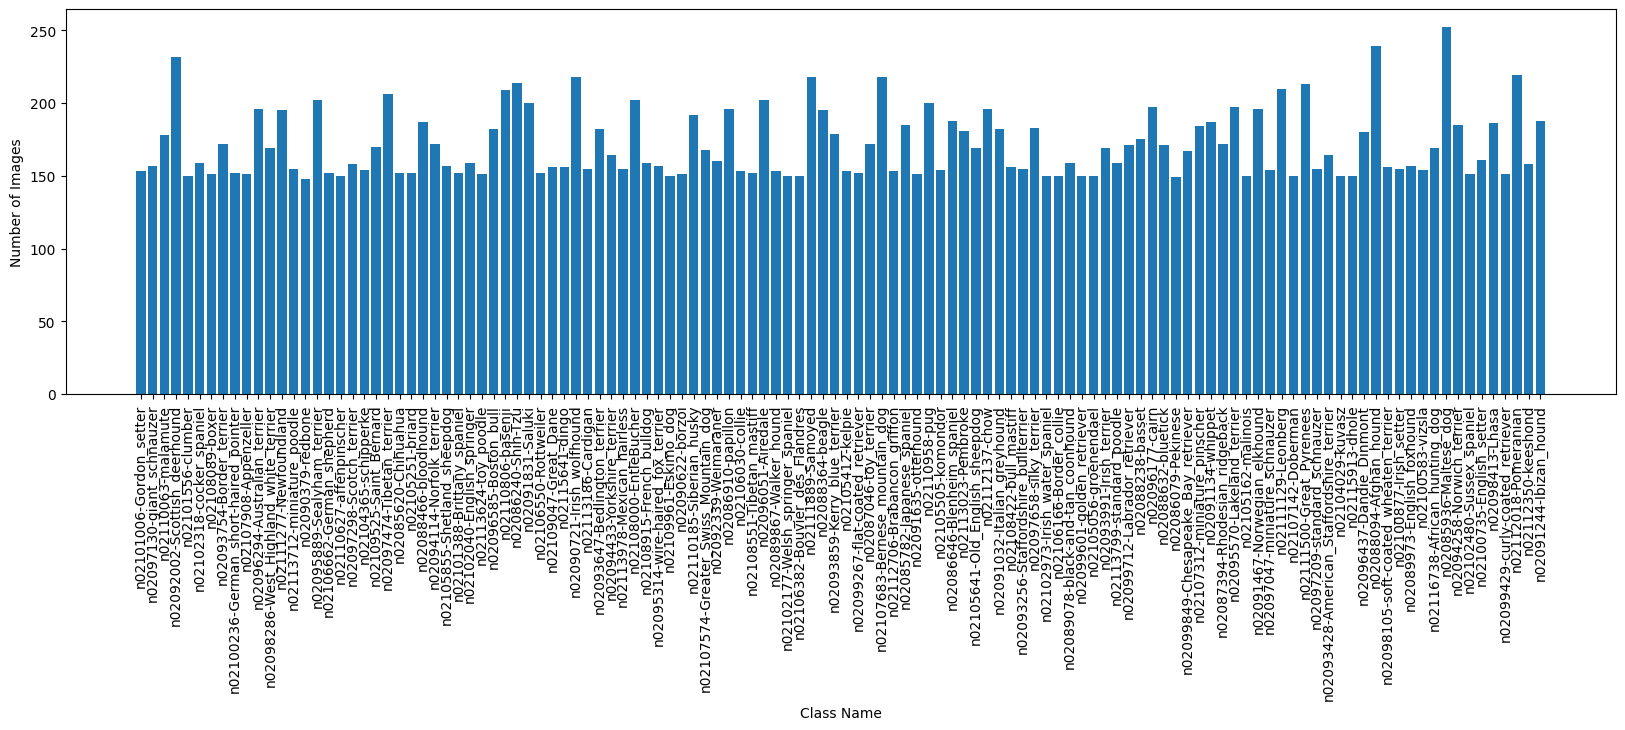

In [4]:
image_counts = [len(os.listdir(data_dir / class_name)) for class_name in class_names]
plt.figure(figsize=(20, 5))
plt.bar(class_names, image_counts)
plt.xticks(rotation=90)
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.show()


# Load using tf.data

In [8]:
import os

def filepaths(data_dir, test_ratio=0.2, validation_ratio=0.2):
    class_names = os.listdir(data_dir)
    n_classes = len(class_names)

    test_ratio = test_ratio
    validation_ratio = validation_ratio

    train_filepaths = []
    valid_filepaths = []
    test_filepaths = []

    for i in range(n_classes):
        img_per_dog = os.listdir(os.path.join(data_dir, class_names[i]))
        img_per_dog = np.array([os.path.join(class_names[i], s) for s in img_per_dog])
        
        total_size = len(img_per_dog)
        test_size = int(total_size * test_ratio)
        validation_size = int(total_size * validation_ratio)
        train_size = total_size - test_size - validation_size

        rnd_indices = np.random.permutation(total_size)

        train_filepaths.append(img_per_dog[rnd_indices[:train_size]])
        valid_filepaths.append(img_per_dog[rnd_indices[train_size:-test_size]])
        test_filepaths.append(img_per_dog[rnd_indices[-test_size:]])

    train_filepaths = np.array([os.path.join(data_dir, s) for s in np.hstack(train_filepaths)])
    valid_filepaths = np.array([os.path.join(data_dir, s) for s in np.hstack(valid_filepaths)])
    test_filepaths = np.array([os.path.join(data_dir, s) for s in np.hstack(test_filepaths)])

    return (train_filepaths, valid_filepaths, test_filepaths)

(train_filepaths, valid_filepaths, test_filepaths) = filepaths(data_dir)
train_filepaths.shape, valid_filepaths.shape, test_filepaths.shape


((12436,), (4072,), (4072,))

In [9]:

norm_layer = layers.experimental.preprocessing.Rescaling(1./255)

def get_label(file_path):
    """Takes the label from the file path"""
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    one_hot = tf.cast(one_hot, tf.float32)
    return tf.argmax(one_hot)

def preprocess_mobilenet(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    final_img = keras.applications.mobilenet_v2.preprocess_input(img)
    return img, label

def create_dataset(filepaths, preprocess, batch_size=32, buffer_size=1000):
    ds = tf.data.Dataset.list_files(filepaths, seed=42)
    ds = ds.map(preprocess, num_parallel_calls=5)
    ds = ds.map(lambda x, y: (norm_layer(x), y), num_parallel_calls=5)
    ds = ds.shuffle(buffer_size, seed=42)
    ds = ds.batch(batch_size)
    return ds.prefetch(1)

# Model 1: MobilNetv2

Create the datasets:

In [10]:
train_set_mobilenet = create_dataset(train_filepaths, preprocess_mobilenet) 
valid_set_mobilenet = create_dataset(valid_filepaths, preprocess_mobilenet)
test_set_mobilenet = create_dataset(test_filepaths, preprocess_mobilenet)

# Data augmentation and Dropout

In [11]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
])

Let's visualize an image after applying the above random transformations:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


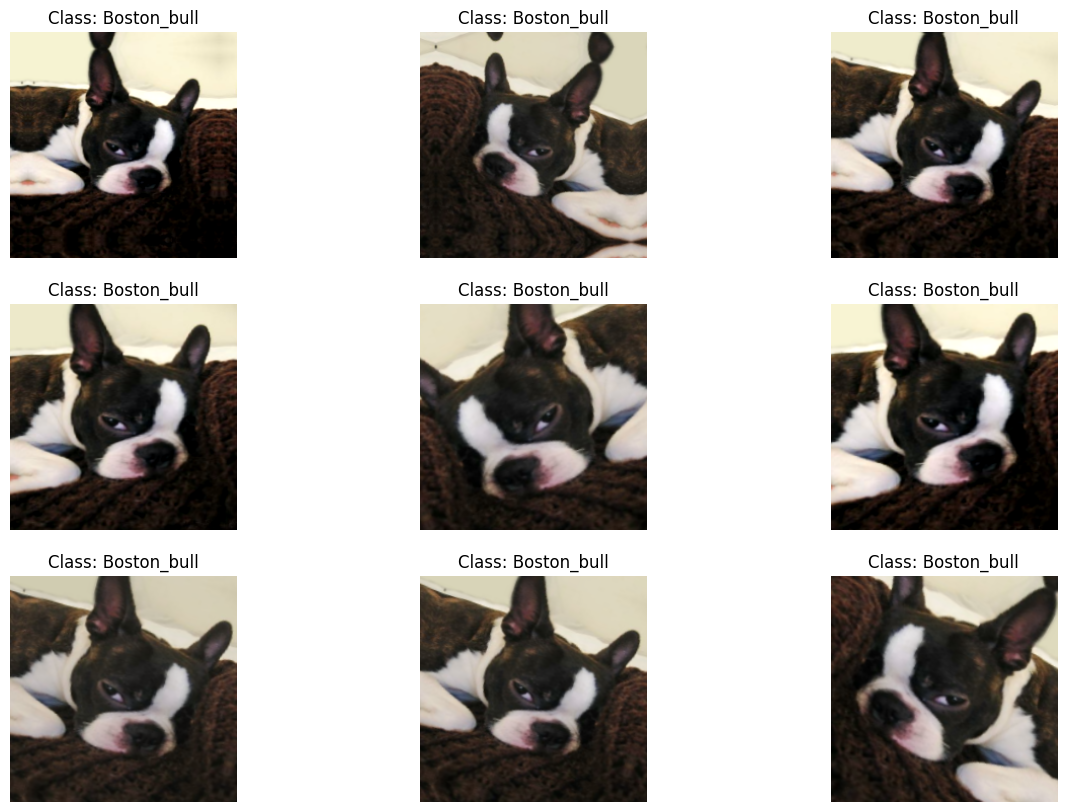

In [ ]:
plt.figure(figsize=(15, 10))
for images, labels in train_set_mobilenet.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0])
        plt.title("Class: " + class_names[labels[0]][10:])
        plt.axis("off")

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

base_model_mobilenet = tf.keras.applications.MobileNetV2(
                                    weights="imagenet", include_top=False)

# Create a new model on top
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model_mobilenet(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)
mobilenet_model = Model(inputs=inputs, outputs=outputs)

# Freeze the weights of the base model
for layer in base_model_mobilenet.layers:
    layer.trainable = False

# Compile the model and start training
mobilenet_model.compile(optimizer=keras.optimizers.Adam(lr=1e-4),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [12]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=3, # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True, # Whether to restore model weights from the epoch with the best value of the monitored quantity.
)
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Define the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create a TensorBoard callback
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
epochs=40
history_mobilenet = mobilenet_model.fit(train_set_mobilenet, epochs=epochs, 
                                        validation_data=valid_set_mobilenet, 
                                        callbacks=[early_stopping_cb, tensorboard_cb])
# Let's save the model before we do fine-tuning
mobilenet_model.save("mobilenet_without_fine_tuning.h5")

Epoch 1/40
389/389 [==============================] - 508s 1s/step - loss: 2.2753 - accuracy: 0.4285 - val_loss: 0.9764 - val_accuracy: 0.7085
Epoch 2/40
389/389 [==============================] - 502s 1s/step - loss: 1.4447 - accuracy: 0.5891 - val_loss: 0.8435 - val_accuracy: 0.7429
Epoch 3/40
389/389 [==============================] - 459s 1s/step - loss: 1.2713 - accuracy: 0.6265 - val_loss: 0.8508 - val_accuracy: 0.7360
Epoch 4/40
389/389 [==============================] - 446s 1s/step - loss: 1.2072 - accuracy: 0.6469 - val_loss: 0.8450 - val_accuracy: 0.7468
Epoch 5/40
389/389 [==============================] - 466s 1s/step - loss: 1.1392 - accuracy: 0.6632 - val_loss: 0.8138 - val_accuracy: 0.7446
Epoch 6/40
389/389 [==============================] - 467s 1s/step - loss: 1.0889 - accuracy: 0.6781 - val_loss: 0.8248 - val_accuracy: 0.7502
Epoch 7/40
389/389 [==============================] - 461s 1s/step - loss: 1.0301 - accuracy: 0.6954 - val_loss: 0.8295 - val_accuracy: 0.7448

# Learning curves

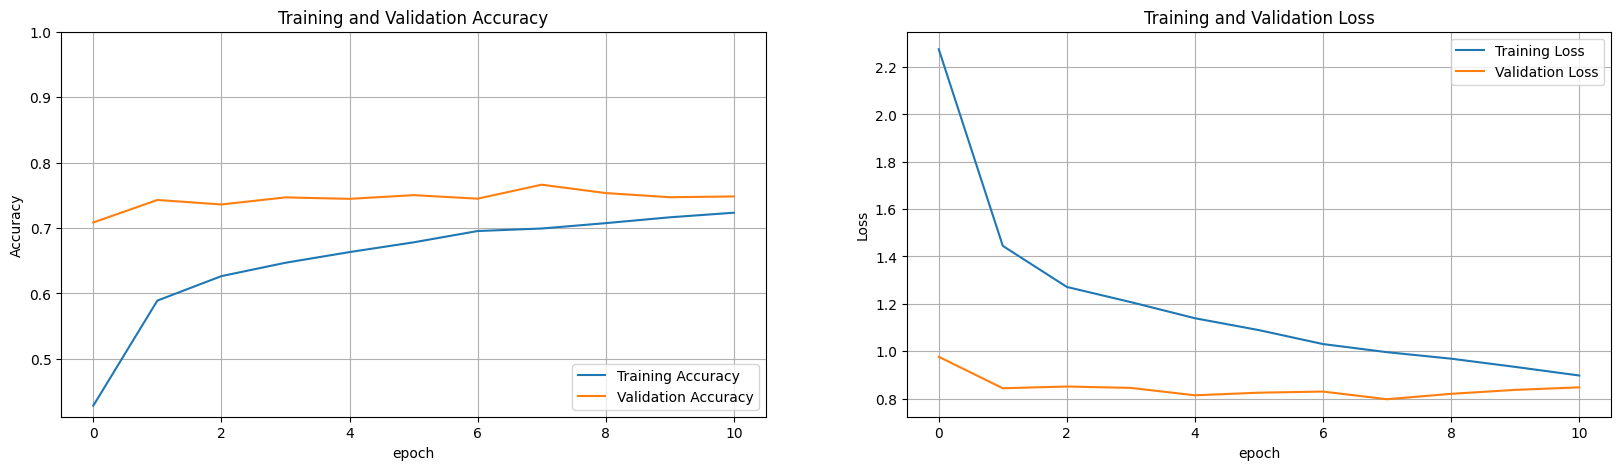

In [ ]:

def plot_learning_curves(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    plt.xlabel('epoch')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.grid(True)
    plt.show()
plot_learning_curves(history_mobilenet)

In [12]:
# Evaluate the final model on the test set
final_model = keras.models.load_model("mobilenet_without_fine_tuning.h5")
loss, accuracy = final_model.evaluate(test_set_mobilenet)
print('Test accuracy :', np.round((accuracy * 100), 2), '%')

128/128 [==============================] - 147s 1s/step - loss: 0.5952 - accuracy: 0.8158
Test accuracy : 81.58 %


## Building the CNN model

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)

# Define the image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Define the model architecture
input_shape = (224, 224, 3)
n_classes = len(train_generator.class_indices)
model = keras.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ]
)

# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,callbacks=[early_stopping_cb, tensorboard_cb]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)

# Print the test accuracy
print("Test accuracy:", test_acc)


Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.
Found 20580 images belonging to 120 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_18 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_19 (Bat  (None, 220, 220, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 110, 110, 32)  

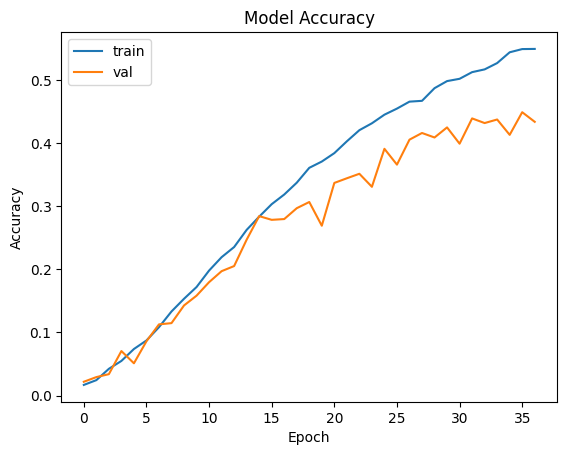

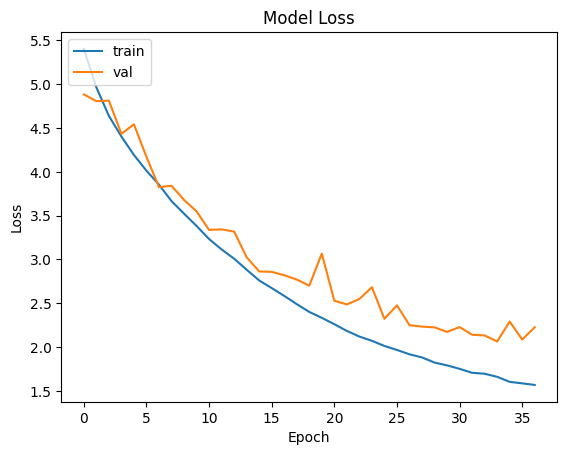

In [14]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## On comparing the test accuracies ,the transfer learning outperformed the CNN model built from the scratch.